In [1]:
import numpy as np
from scipy.special import softmax
from matplotlib import pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pandas as pd

## Define gain modulated ELM architecture

In [8]:
class GMELM:
    
    def __init__ (self, par):
        # This are the network size N, input I, output O and max temporal span T
        self.N, self.I, self.Ia = par['shape'][0], par["shape"][1], par["shape"][2]
        self.par = par
        # This is the network input, teach and output matrices
        Jin1 = np.random.normal(0., par['sigma_Jin']/np.sqrt(self.I), size = (self.I, self.N))
        Jin2 = np.random.normal(0., par['sigma_Jap']/np.sqrt(self.Ia), size = (self.Ia, self.N))
        self.Jin = np.concatenate([Jin1, Jin2])
        self.bin = np.random.normal(0., par['sigma_bin'], size = (self.N)) 

        self.H = np.zeros(self.N)
        
        
        self.Jap =  Jin2*np.sin(self.par["gamma"]*np.pi/4)
        
        self.bap = np.random.normal(size=(self.N))*par["sigma_bap"]*np.cos(self.par["gamma"]*np.pi/4); 
        self.phi = par["phi"]
        self.Jout = None
        
    def get_features(self, inp, gain): 
        g = (self.bap + (gain)@self.Jap)
        inp = np.concatenate([inp, gain], 1)
        self.H = self.phi(g*(inp@self.Jin + self.bin))
       
        return self.H




    def __call__(self, inp, gain): 
        self.get_features(inp, gain)
        return self.H@self.Jout
        #return self.clf.predict(self.H[None,:])[0]
    
    def train(self, X_in, X_ap, Y, alpha=0):
        
        H = self.get_features(X_in, X_ap)
        n_col = H.shape[1]
        self.Jout = np.linalg.lstsq(H.T.dot(H) + alpha * np.identity(n_col), H.T.dot(Y), rcond=None)[0]
        #self.Jout = np.linalg.pinv(H)@Y

In [9]:
def test_product(par_gm, n_train, n_test, n_trials):
    err_train = []
    err_test = []
    for n in range(n_trials):
        xs = np.random.uniform(size=(n_train, par_gm["dim"]))
        ws = np.random.uniform(size=(n_train, par_gm["dim"]))
        ys = np.mean(ws*xs, 1)
        net = GMELM(par=par_gm)
        net.train(xs, ws, ys)
        
        # test
        
        xs_test = np.random.uniform(size=(n_test, dim))*2 - 1
        ws_test = np.random.uniform(size=(n_test, dim))*2 - 1
        ys_test = np.mean(ws_test*xs_test, 1)
        err_train.append(np.sqrt(np.mean((net(xs, ws) - ys)**2)))
        err_test.append(np.sqrt(np.mean((net(xs_test, ws_test) - ys_test)**2)))
    dic = deepcopy(par_gm)
    dic['err_train'] = np.array(err_train)
    dic['err_test'] = np.array(err_test)
    return dic

# DOT PRODUCT

## Hyperparameter search 

In [562]:
results_hyper = []
n_trials = 100
n_train = 2000
n_test = 1000
dim = 5
feat = 50

for gamma in [0,1]:
    for phi in [np.tanh, lambda x: np.log(1 + np.exp(x))]:
        for sigma in tqdm(np.round(10**(np.linspace(-2, 0, 10)), 2)):
            for bias in np.arange(0, 2.1, 0.1):
                N, I, Ia = feat, dim, dim
                sigma_in = sigma
                sigma_Jin = sigma
                sigma_bin = bias
                sigma_bap = sigma
                sigma_Jap = sigma
                # Here we build the dictionary of the simulation parameters
                par_gm = {
                  'sigma_Jin' : sigma_Jin,
                  "sigma_bin": sigma_bin,
                  "sigma_bap": sigma_bap,
                  "sigma_Jap": sigma_Jap,
                  'gamma': gamma, 
                  'phi': phi,
                  'sigma': sigma, 
                  "bias": bias, 
                #  "phi": lambda x: np.log(1 + np.exp(x)),
                  }

                par_gm["shape"] = (N, I, Ia)
                par_gm["dim"] = dim
                dic = test_product(par_gm, n_train, n_test, n_trials)
                dic['dim'] = dim
                dic['feat_dim'] = feat
                results_hyper.append(dic)

100%|██████████| 10/10 [03:44<00:00, 22.49s/it]


In [563]:
df_hyper = pd.DataFrame(results_hyper)
df_hyper["log_rmse_test"] = df_hyper["err_test"].apply(lambda x: np.mean(np.log10(x)))
df_best = df_hyper.sort_values("log_rmse_test").drop_duplicates(subset="gamma")
hyperparams = {i: df_best.loc[df_best['gamma'] == i][['phi', 'sigma', 'bias']].iloc[0].to_dict() for i in [0,1]}
print(hyperparams[0])
print(hyperparams[1])

{'phi': <function <lambda> at 0x7fb1291de050>, 'sigma': 0.6, 'bias': 0.4}
{'phi': <ufunc 'tanh'>, 'sigma': 0.01, 'bias': 0.0}


## Train models

In [564]:
results = []
n_trials = 100
n_train = 2000
n_test = 500
maxdim = 10
maxfeat = 200

sigma = {1: 0.05, 0: 0.02}
bias = {1: 0.00, 0: 0.0}
for gamma in [0,1]:
    for feat_dim in  tqdm(range(1,maxfeat+1, 10)):
        for dim in range(1,maxdim+1):
            N, I, Ia = feat_dim, dim, dim
            # Here we build the dictionary of the simulation parameters
            par_gm = {
                'sigma_Jin' : hyperparams[gamma]["sigma"],
                "sigma_bin": hyperparams[gamma]["bias"],
                "sigma_bap": hyperparams[gamma]["sigma"],
                "sigma_Jap": hyperparams[gamma]["sigma"],
                'gamma': gamma, 
              #  'phi': np.tanh,
                "phi": hyperparams[gamma]["phi"],
                }

            par_gm["shape"] = (N, I, Ia)
            par_gm["dim"] = dim
            dic = test_product(par_gm, n_train, n_test, n_trials)
            dic['dim'] = dim
            dic['feat_dim'] = feat_dim
            results.append(dic)

100%|██████████| 20/20 [04:39<00:00, 13.99s/it]


## Produce panels

In [565]:
df = pd.DataFrame(results)
df.tail()

,sigma_Jin,sigma_bin,sigma_bap,sigma_Jap,gamma,phi,shape,dim,err_train,err_test,feat_dim
395,0.01,0.0,0.01,0.01,1,<ufunc 'tanh'>,"(191, 6, 6)",6,"[1.716079948574383e-09, 3.2454882123446995e-09...","[1.9337527627238044e-08, 5.1079085302344944e-0...",191
396,0.01,0.0,0.01,0.01,1,<ufunc 'tanh'>,"(191, 7, 7)",7,"[1.526476914190516e-09, 1.6927744260892229e-09...","[1.880057961532006e-08, 1.8838816628739744e-08...",191
397,0.01,0.0,0.01,0.01,1,<ufunc 'tanh'>,"(191, 8, 8)",8,"[1.4934961166577616e-09, 2.016674563125288e-09...","[2.252755450855617e-08, 2.5567777114118578e-08...",191
398,0.01,0.0,0.01,0.01,1,<ufunc 'tanh'>,"(191, 9, 9)",9,"[2.6810387329792477e-09, 1.4803429147667931e-0...","[3.799015761960406e-08, 2.1721290379091154e-08...",191
399,0.01,0.0,0.01,0.01,1,<ufunc 'tanh'>,"(191, 10, 10)",10,"[3.4527660119174506e-09, 4.087407099876722e-09...","[4.561671307834107e-08, 5.7626682616088205e-08...",191


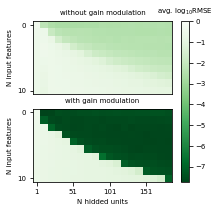

In [566]:
err = "err_test"
grid = np.indices((maxdim,maxfeat//10 - 1))
err0 = np.vectorize(lambda i, j: (np.mean(np.log10(df.loc[(df["dim"]==i)&
                                             (df["feat_dim"]==j)&
                                             (df["gamma"]==0)
                                           ].iloc[0][err]))))(grid[0]+1, 10*(grid[1])+1)
err1 = np.vectorize(lambda i, j: (np.mean(np.log10(df.loc[(df["dim"]==i)&
                                             (df["feat_dim"]==j)&
                                             (df["gamma"]==1)
                                           ].iloc[0][err]))))(grid[0]+1, 10*(grid[1])+1)

min = np.min(err1)

mm = 1/25.4  # mm in inches

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(80*mm, 75*mm)) 
ax1.set_title('without gain modulation', fontsize=7)
ax2.set_title('with gain modulation', fontsize=7)

im1 = ax1.imshow(err0, cmap='Greens_r', vmin=min, vmax=0)
ax1.set_xticks([])
ax1.set_yticks([0,maxdim-1])
ax1.set_yticklabels([0, maxdim])
im2 = ax2.imshow(err1, cmap='Greens_r', vmin=min, vmax=0)
ax2.set_xticks([0,5,10,15])
ax2.set_yticks([0,maxdim-1])
ax2.set_yticklabels([0, maxdim])
ax2.set_xticklabels([1,51,101,151])
cb = plt.colorbar(im1, ax=[ax1, ax2])
cb.ax.tick_params(labelsize=7)
ax1.tick_params(axis='both', labelsize=7)
ax2.tick_params(axis='both', labelsize=7)
plt.text(16.5,-13.5, "avg. $ \\log_{10}$RMSE", fontsize=7)
ax2.set_xlabel("N hidded units", fontsize=7)
ax1.set_ylabel("N input features", fontsize=7)
ax2.set_ylabel("N input features", fontsize=7)
plt.savefig("dot_prod_1.pdf", bbox_inches='tight')

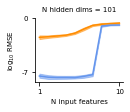

In [582]:
fig, ax = plt.subplots(figsize=(40*mm, 30*mm)) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('N hidden dims = 101', fontsize=7)

c0 = "darkorange"
c1 = "cornflowerblue"

df[(df["feat_dim"] == 101)&(df["gamma"] == 0)]['err_train']
ax.tick_params(axis='both', labelsize=7)

dims = df[(df["feat_dim"] == 101)&(df["gamma"] == 0)]["dim"]
e0train = df[(df["feat_dim"] == 101)&(df["gamma"] == 0)]['err_train']
e0train = np.stack(e0train.apply(lambda x: np.log10(np.percentile(x, [20, 50, 80]))))
e0test = df[(df["feat_dim"] == 101)&(df["gamma"] == 0)]['err_test']
e0test = np.stack(e0test.apply(lambda x: np.log10(np.percentile(x, [20, 50, 80]))))

plt.plot(dims, e0test[:,1], color=c0, label="$\\gamma=0$")

e1train = df[(df["feat_dim"] == 101)&(df["gamma"] == 1)]['err_train']
e1train = np.stack(e1train.apply(lambda x: np.log10(np.percentile(x, [20, 50, 80]))))
e1test = df[(df["feat_dim"] == 101)&(df["gamma"] == 1)]['err_test']
e1test = np.stack(e1test.apply(lambda x: np.log10(np.percentile(x, [20, 50, 80]))))
ax.set_ylabel("$\\log_{10}$ RMSE", fontdict={'size': 7})
ax.set_xlabel("N input features", fontdict={'size': 7})

plt.plot(dims, e1test[:,1], color=c1, label="$\\gamma=1$")
plt.fill_between(dims, e1test[:,0], e1test[:,2], color=c1, alpha=0.5)
plt.fill_between(dims, e0test[:,0], e0test[:,2], color=c0, alpha=0.5)
ax.set_yticks([0.0,-7])
ax.set_yticklabels(["0","-7"])
ax.set_xticks([1,10])
plt.savefig("dot_prod_2.pdf", bbox_inches='tight')

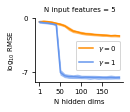

In [580]:
fig, ax = plt.subplots(figsize=(40*mm, 30*mm)) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('N input features = 5', fontsize=7)

c0 = "darkorange"
c1 = "cornflowerblue"

ax.tick_params(axis='both', labelsize=7)
ax.set_xticks([1,50,100,150])

dims = df[(df["dim"] == 5)&(df["gamma"] == 0)]["feat_dim"]
e0train = df[(df["dim"] == 5)&(df["gamma"] == 0)]['err_train']
e0train = np.stack(e0train.apply(lambda x: np.log10(np.percentile(x, [20, 50, 80]))))
e0test = df[(df["dim"] == 5)&(df["gamma"] == 0)]['err_test']
e0test = np.stack(e0test.apply(lambda x: np.log10(np.percentile(x, [20, 50, 80]))))

plt.plot(dims, e0test[:,1], color=c0, label="$\\gamma=0$")

e1train = df[(df["dim"] == 5)&(df["gamma"] == 1)]['err_train']
e1train = np.stack(e1train.apply(lambda x: np.log10(np.percentile(x, [20, 50, 80]))))
e1test = df[(df["dim"] == 5)&(df["gamma"] == 1)]['err_test']
e1test = np.stack(e1test.apply(lambda x: np.log10(np.percentile(x, [20, 50, 80]))))
ax.set_ylabel("$\\log_{10}$ RMSE", fontdict={'size': 7})
ax.set_xlabel("N hidden dims", fontdict={'size': 7})

plt.plot(dims, e1test[:,1], color=c1, label="$\\gamma=1$")
plt.fill_between(dims, e1test[:,0], e1test[:,2], color=c1, alpha=0.5)
plt.fill_between(dims, e0test[:,0], e0test[:,2], color=c0, alpha=0.5)
ax.set_yticks([0.0,-7])
ax.set_yticklabels(["0","-7"])
ax.legend(loc=4, prop={'size': 7}, bbox_to_anchor=(1.0, .13))
plt.savefig("dot_prod_3.pdf", bbox_inches='tight')

# VECTORxSCALAR PRODUCT

In [478]:
def test_vs_product(par_gm, n_train, n_test, n_trials):
    err_train = []
    err_test = []
    for n in range(n_trials):
        xs = np.random.uniform(size=(n_train, par_gm["dim"]))
        ws = np.random.uniform(size=(n_train, 1))
        ys = ws*xs
        net = GMELM(par=par_gm)
        net.train(xs, ws, ys)
        
        # test
        
        xs_test = np.random.uniform(size=(n_test, dim))*2 - 1
        ws_test = np.random.uniform(size=(n_test, 1))*2 - 1
        ys_test = ws_test*xs_test
        err_train.append(np.sqrt(np.mean((net(xs, ws) - ys)**2)))
        err_test.append(np.sqrt(np.mean((net(xs_test, ws_test) - ys_test)**2)))
    dic = deepcopy(par_gm)
    dic['err_train'] = np.array(err_train)
    dic['err_test'] = np.array(err_test)
    return dic

## Hyperparameter search

In [479]:
results_hyper = []
n_trials = 100
n_train = 2000
n_test = 1000
dim = 5
feat = 20

for gamma in [0,1]:
    for phi in [np.tanh, lambda x: np.log(1 + np.exp(x))]:
        for sigma in tqdm(np.round(10**(np.linspace(-2, 0, 10)), 2)):
            for bias in np.arange(0, 2.1, 0.1):
                N, I, Ia = feat, dim, 1
                sigma_in = sigma
                sigma_Jin = sigma
                sigma_bin = bias
                sigma_bap = sigma
                sigma_Jap = sigma
                # Here we build the dictionary of the simulation parameters
                par_gm = {
                  'sigma_Jin' : sigma_Jin,
                  "sigma_bin": sigma_bin,
                  "sigma_bap": sigma_bap,
                  "sigma_Jap": sigma_Jap,
                  'gamma': gamma, 
                  'phi': phi,
                  'sigma': sigma, 
                  "bias": bias, 
                #  "phi": lambda x: np.log(1 + np.exp(x)),
                  }

                par_gm["shape"] = (N, I, Ia)
                par_gm["dim"] = dim
                dic = test_vs_product(par_gm, n_train, n_test, n_trials)
                dic['dim'] = dim
                dic['feat_dim'] = feat
                results_hyper.append(dic)

100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


In [480]:
df_hyper = pd.DataFrame(results_hyper)
df_hyper["log_rmse_test"] = df_hyper["err_test"].apply(lambda x: np.mean(np.log10(x)))
df_best = df_hyper.sort_values("log_rmse_test").drop_duplicates(subset="gamma")
hyperparams = {i: df_best.loc[df_best['gamma'] == i][['phi', 'sigma', 'bias']].iloc[0].to_dict() for i in [0,1]}
print(hyperparams[0])
print(hyperparams[1])

{'phi': <function <lambda> at 0x7fb118734560>, 'sigma': 0.36, 'bias': 0.2}
{'phi': <ufunc 'tanh'>, 'sigma': 0.01, 'bias': 0.0}


## Train models

In [481]:
results = []
n_trials = 100
n_train = 2000
n_test = 500
maxdim = 10
maxfeat = 40


for gamma in [0,1]:
    for feat_dim in  tqdm(range(1,maxfeat+1, 2)):
        for dim in range(1,maxdim+1):
            N, I, Ia = feat_dim, dim, 1
            # Here we build the dictionary of the simulation parameters
            par_gm = {
                'sigma_Jin' : hyperparams[gamma]["sigma"],
                "sigma_bin": hyperparams[gamma]["bias"],
                "sigma_bap": hyperparams[gamma]["sigma"],
                "sigma_Jap": hyperparams[gamma]["sigma"],
                'gamma': gamma, 
              #  'phi': np.tanh,
                "phi": hyperparams[gamma]["phi"],
                }

            par_gm["shape"] = (N, I, Ia)
            par_gm["dim"] = dim
            dic = test_vs_product(par_gm, n_train, n_test, n_trials)
            dic['dim'] = dim
            dic['feat_dim'] = feat_dim
            results.append(dic)

100%|██████████| 20/20 [01:01<00:00,  3.05s/it]


## Produce panels

In [483]:
df = pd.DataFrame(results)
df.tail()

,sigma_Jin,sigma_bin,sigma_bap,sigma_Jap,gamma,phi,shape,dim,err_train,err_test,feat_dim
395,0.01,0.0,0.01,0.01,1,<ufunc 'tanh'>,"(39, 6, 1)",6,"[3.9923193832076714e-09, 8.912660128932024e-09...","[5.152148385844012e-08, 9.7521008249095e-08, 4...",39
396,0.01,0.0,0.01,0.01,1,<ufunc 'tanh'>,"(39, 7, 1)",7,"[3.557739718059229e-09, 7.3022303631688655e-09...","[3.923667263381854e-08, 8.247545722390362e-08,...",39
397,0.01,0.0,0.01,0.01,1,<ufunc 'tanh'>,"(39, 8, 1)",8,"[5.4064521096962284e-09, 3.698228010224548e-09...","[5.22928251894024e-08, 3.757677555720156e-08, ...",39
398,0.01,0.0,0.01,0.01,1,<ufunc 'tanh'>,"(39, 9, 1)",9,"[3.925659676353928e-09, 3.244269967199867e-09,...","[5.852650960577342e-08, 2.5141547293772687e-08...",39
399,0.01,0.0,0.01,0.01,1,<ufunc 'tanh'>,"(39, 10, 1)",10,"[1.244378541947408e-08, 1.7900768821242863e-08...","[1.4190480081502054e-07, 2.440560624856685e-07...",39


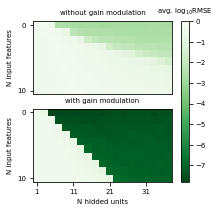

In [509]:
mm = 1/25.4  # mm in inches


err = "err_test"
grid = np.indices((maxdim,maxfeat//2 - 1))
err0 = np.vectorize(lambda i, j: (np.mean(np.log10(df.loc[(df["dim"]==i)&
                                             (df["feat_dim"]==j)&
                                             (df["gamma"]==0)
                                           ].iloc[0][err]))))(grid[0]+1, 2*(grid[1])+1)
err1 = np.vectorize(lambda i, j: (np.mean(np.log10(df.loc[(df["dim"]==i)&
                                             (df["feat_dim"]==j)&
                                             (df["gamma"]==1)
                                           ].iloc[0][err]))))(grid[0]+1, 2*(grid[1])+1)

min = np.min(err1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(80*mm, 75*mm)) 
ax1.set_title('without gain modulation', fontsize=7)
ax2.set_title('with gain modulation', fontsize=7)

im1 = ax1.imshow(err0, cmap='Greens_r', vmin=min, vmax=0)
ax1.set_xticks([])
ax1.set_yticks([0,maxdim-1])
ax1.set_yticklabels([0, maxdim])
im2 = ax2.imshow(err1, cmap='Greens_r', vmin=min, vmax=0)
ax2.set_xticks([0,5,10,15])
ax2.set_yticks([0,maxdim-1])
ax2.set_yticklabels([0, maxdim])
ax2.set_xticklabels([1,11, 21 , 31])
cb = plt.colorbar(im1, ax=[ax1, ax2])
cb.ax.tick_params(labelsize=7)
ax1.tick_params(axis='both', labelsize=7)
ax2.tick_params(axis='both', labelsize=7)
plt.text(16.5,-13.5, "avg. $ \\log_{10}$RMSE", fontsize=7)
ax2.set_xlabel("N hidded units", fontsize=7)
ax1.set_ylabel("N input features", fontsize=7)
ax2.set_ylabel("N input features", fontsize=7)
plt.savefig("sv_prod_1.pdf", bbox_inches='tight')

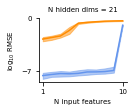

In [546]:
fig, ax = plt.subplots(figsize=(40*mm, 30*mm)) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('N hidden dims = 21', fontsize=7)

c0 = "darkorange"
c1 = "cornflowerblue"

df[(df["feat_dim"] == 21)&(df["gamma"] == 0)]['err_train']
ax.tick_params(axis='both', labelsize=7)
ax.set_xticks([1,10])
ax.set_yticks([0,-7])
dims = df[(df["feat_dim"] == 21)&(df["gamma"] == 0)]["dim"]
e0train = df[(df["feat_dim"] == 21)&(df["gamma"] == 0)]['err_train']
e0train = np.stack(e0train.apply(lambda x: np.log10(np.percentile(x, [20, 50, 80]))))
e0test = df[(df["feat_dim"] == 21)&(df["gamma"] == 0)]['err_test']
e0test = np.stack(e0test.apply(lambda x: np.log10(np.percentile(x, [20, 50, 80]))))

plt.plot(dims, e0test[:,1], color=c0, label="$\\gamma=0$")

e1train = df[(df["feat_dim"] == 21)&(df["gamma"] == 1)]['err_train']
e1train = np.stack(e1train.apply(lambda x: np.log10(np.percentile(x, [20, 50, 80]))))
e1test = df[(df["feat_dim"] == 21)&(df["gamma"] == 1)]['err_test']
e1test = np.stack(e1test.apply(lambda x: np.log10(np.percentile(x, [20, 50, 80]))))
ax.set_ylabel("$\log_{10}$ RMSE", fontdict={'size': 7})
ax.set_xlabel("N input features", fontdict={'size': 7})

plt.plot(dims, e1test[:,1], color=c1, label="$\\gamma=1$")
plt.fill_between(dims, e1test[:,0], e1test[:,2], color=c1, alpha=0.5)
plt.fill_between(dims, e0test[:,0], e0test[:,2], color=c0, alpha=0.5)
plt.savefig("sv_prod_2.pdf", bbox_inches='tight')

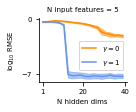

In [561]:
fig, ax = plt.subplots(figsize=(40*mm, 30*mm)) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('N input features = 5', fontsize=7)

c0 = "darkorange"
c1 = "cornflowerblue"

ax.tick_params(axis='both', labelsize=7)
ax.set_xticks([1,20,40])
ax.set_yticks([0,-7])
dims = df[(df["dim"] == 5)&(df["gamma"] == 0)]["feat_dim"]
e0train = df[(df["dim"] == 5)&(df["gamma"] == 0)]['err_train']
e0train = np.stack(e0train.apply(lambda x: np.log10(np.percentile(x, [20, 50, 80]))))
e0test = df[(df["dim"] == 5)&(df["gamma"] == 0)]['err_test']
e0test = np.stack(e0test.apply(lambda x: np.log10(np.percentile(x, [20, 50, 80]))))

plt.plot(dims, e0test[:,1], color=c0, label="$\\gamma=0$")

e1train = df[(df["dim"] == 5)&(df["gamma"] == 1)]['err_train']
e1train = np.stack(e1train.apply(lambda x: np.log10(np.percentile(x, [20, 50, 80]))))
e1test = df[(df["dim"] == 5)&(df["gamma"] == 1)]['err_test']
e1test = np.stack(e1test.apply(lambda x: np.log10(np.percentile(x, [20, 50, 80]))))
ax.set_ylabel("$\\log_{10}$ RMSE", fontdict={'size': 7})
ax.set_xlabel("N hidden dims", fontdict={'size': 7})

plt.plot(dims, e1test[:,1], color=c1, label="$\\gamma=1$")
plt.fill_between(dims, e1test[:,0], e1test[:,2], color=c1, alpha=0.5)
plt.fill_between(dims, e0test[:,0], e0test[:,2], color=c0, alpha=0.5)
ax.legend(loc=4, prop={'size': 7}, bbox_to_anchor=(1.0, .13))
plt.savefig("sv_prod_3.pdf", bbox_inches='tight')